In [1]:
import sklearn.datasets
import umap
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

In [2]:
digits = sklearn.datasets.fetch_openml('mnist_784')

In [3]:
import seaborn as sns
from sklearn.manifold import TSNE

In [4]:
tsne_map = TSNE().fit_transform(digits.data)

/disk/home/lmmcinn/.conda/envs/naming_topics/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/disk/home/lmmcinn/.conda/envs/naming_topics/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [5]:
symmetric_graph, _, _ = umap.umap_.fuzzy_simplicial_set(digits.data, n_neighbors=15, metric="euclidean", random_state=42)
# symmetric_graph[np.arange(symmetric_graph.shape[0]), np.arange(symmetric_graph.shape[0])] = 1.0
umap_graph = symmetric_graph.copy()
directed_graph, _, _ = umap.umap_.fuzzy_simplicial_set(digits.data, n_neighbors=15, metric="euclidean", random_state=42, apply_set_operations=False)
directed_graph = directed_graph.tocsr()

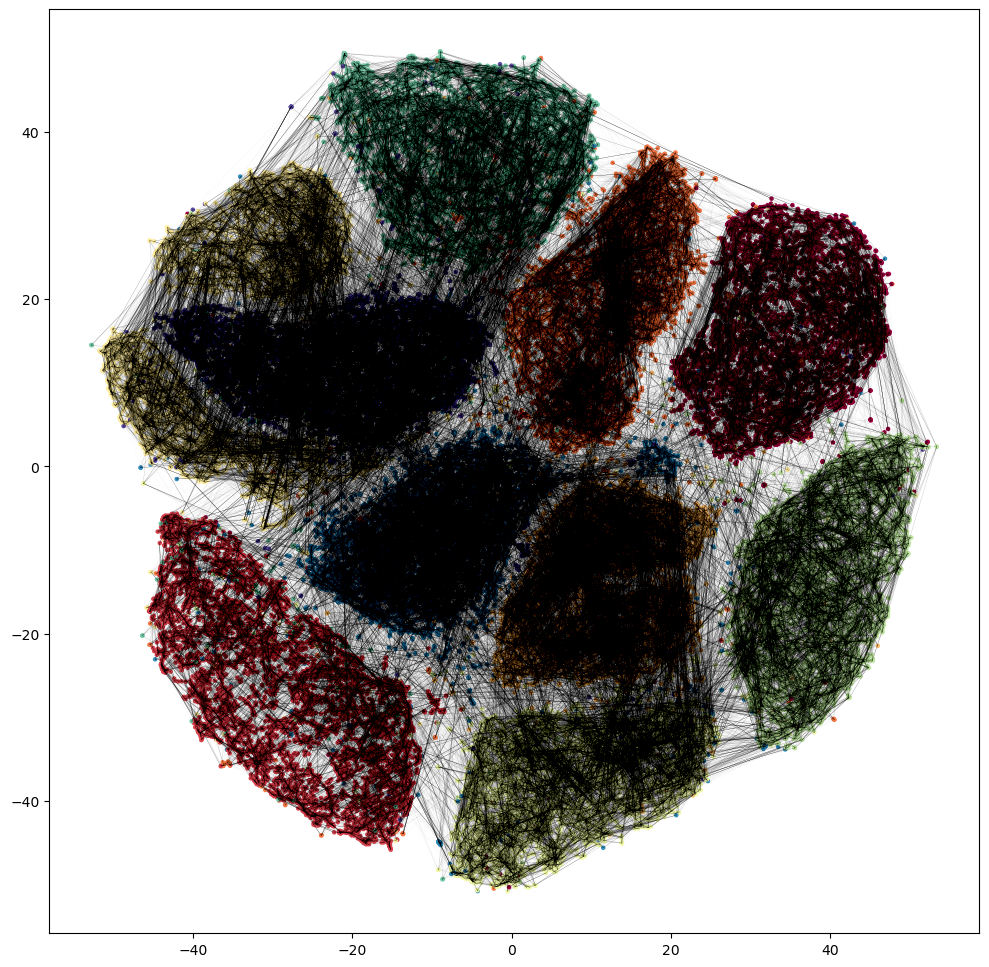

In [6]:
fig, ax = plt.subplots(figsize=(12,12))
coo_umap_graph = umap_graph.tocoo()
edges = LineCollection(
    np.dstack([tsne_map[coo_umap_graph.row], tsne_map[coo_umap_graph.col]]).transpose((0, 2, 1)), 
    linewidths=0.1 * coo_umap_graph.data, 
    colors=np.vstack([np.zeros((3, coo_umap_graph.data.shape[0])), coo_umap_graph.data]).T,
    zorder=3
)
ax.add_collection(edges)
# for idx in range(coo_umap_graph.row.shape[0]):
#     i, j, weight = coo_umap_graph.row[idx], coo_umap_graph.col[idx], coo_umap_graph.data[idx]
#     ax.plot(map.T[0][[i, j]], map.T[1][[i, j]], lw=weight*0.5, c='k', alpha=weight)
ax.scatter(*tsne_map.T, s=5, c=[int(x) for x in digits.target], cmap="Spectral")

In [7]:
from sklearn.preprocessing import normalize
import scipy.sparse.csgraph
import scipy.sparse
import numba

In [8]:
@numba.njit()
def custom_pointwise_multiply(left_indptr, left_indices, left_data, right_indptr, right_indices, right_data):
    
    n_rows = left_indptr.shape[0] - 1
    
    for i in range(n_rows):
        for k in range(left_indptr[i], left_indptr[i+1]):
            j = left_indices[k]
            
            for l in range(right_indptr[i], right_indptr[i+1]):
                if right_indices[l] == j:
                    left_data[k] *= 1.0 - right_data[l]
                    
    return

def neg_sample_graph(graph, n_neg_samples=5*15):
    col_indices = []
    for i in range(graph.shape[0]):
        prob = np.squeeze((1.0 - graph[i].toarray()))
        prob /= prob.sum()
        col_indices.append(np.random.choice(prob.shape[0], size=n_neg_samples, p=prob, replace=False))
    col_indices = np.hstack(col_indices)
    return scipy.sparse.coo_matrix((np.ones(col_indices.shape[0]), (np.repeat(np.arange(graph.shape[0]), n_neg_samples), col_indices)))

In [9]:
%%time
umap_graph = directed_graph
new_graph = (umap_graph * umap_graph).tocoo()
new_graph.setdiag(0.0)
new_graph = normalize(new_graph, norm="max")
new_graph.eliminate_zeros()

for i in range(100):
    print(f"Iteration {i} ...")
    negative_samples = neg_sample_graph(umap_graph, n_neg_samples=225)
    anti_diffusion_graph = (negative_samples * umap_graph).tocoo()
    anti_diffusion_graph.setdiag(0.0)
    anti_diffusion_graph.setdiag(np.squeeze(np.asarray(anti_diffusion_graph.max(axis=1).toarray())))
    anti_diffusion_graph = normalize(anti_diffusion_graph, norm="max")
    anti_diffusion_graph.eliminate_zeros()
    custom_pointwise_multiply(
        new_graph.indptr, new_graph.indices, new_graph.data, 
        anti_diffusion_graph.indptr, anti_diffusion_graph.indices, anti_diffusion_graph.data
    )
    new_graph = normalize(new_graph, norm="max")
    new_graph.data[new_graph.data < 0.1] = 0.0
    new_graph.eliminate_zeros()
    new_graph = (new_graph * new_graph).tocoo()
    new_graph.setdiag(0.0)
    new_graph = normalize(new_graph, norm="max")
    new_graph.eliminate_zeros()

Iteration 0 ...
Iteration 1 ...
Iteration 2 ...
Iteration 3 ...
Iteration 4 ...
Iteration 5 ...
Iteration 6 ...
Iteration 7 ...
Iteration 8 ...
Iteration 9 ...
Iteration 10 ...
Iteration 11 ...
Iteration 12 ...
Iteration 13 ...
Iteration 14 ...
Iteration 15 ...
Iteration 16 ...
Iteration 17 ...
Iteration 18 ...
Iteration 19 ...
Iteration 20 ...
Iteration 21 ...
Iteration 22 ...
Iteration 23 ...
Iteration 24 ...
Iteration 25 ...
Iteration 26 ...
Iteration 27 ...
Iteration 28 ...
Iteration 29 ...
Iteration 30 ...
Iteration 31 ...
Iteration 32 ...
Iteration 33 ...
Iteration 34 ...
Iteration 35 ...
Iteration 36 ...
Iteration 37 ...
Iteration 38 ...
Iteration 39 ...
Iteration 40 ...
Iteration 41 ...
Iteration 42 ...
Iteration 43 ...
Iteration 44 ...
Iteration 45 ...
Iteration 46 ...
Iteration 47 ...
Iteration 48 ...
Iteration 49 ...
Iteration 50 ...
Iteration 51 ...
Iteration 52 ...
Iteration 53 ...
Iteration 54 ...
Iteration 55 ...
Iteration 56 ...
Iteration 57 ...
Iteration 58 ...
Iterati

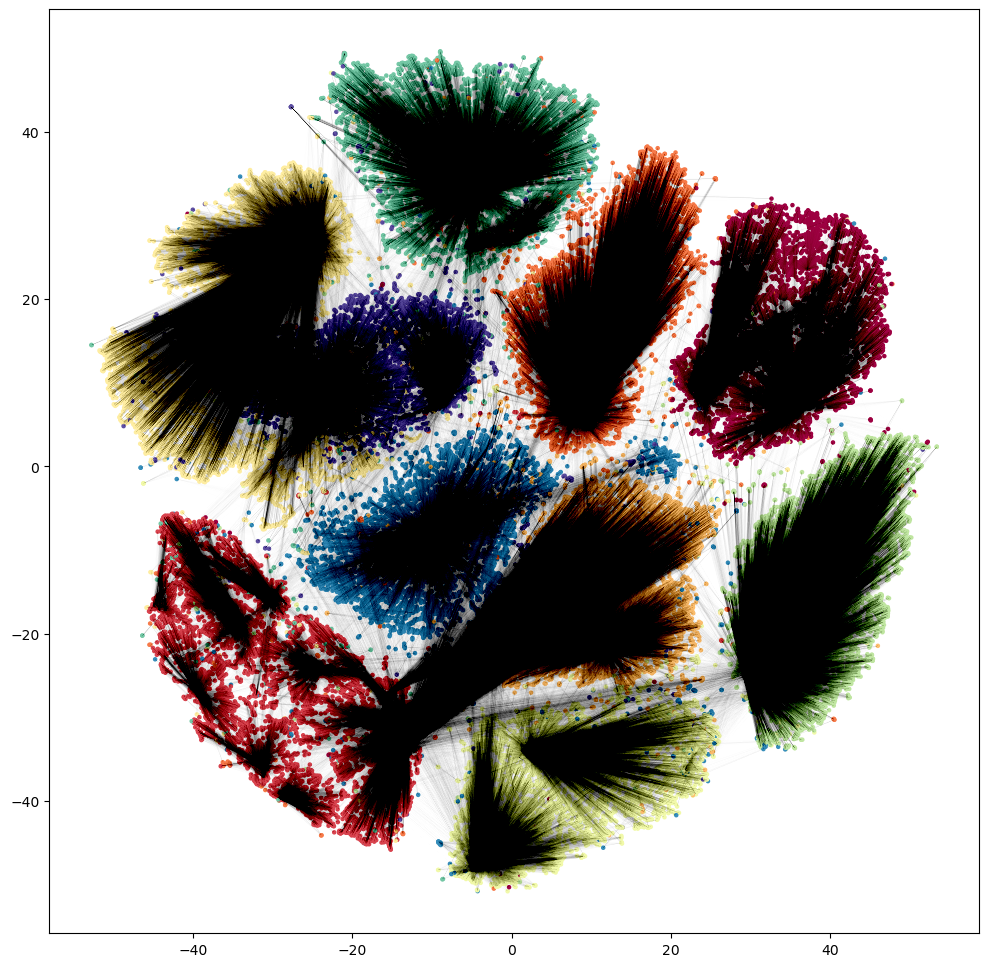

In [10]:
fig, ax = plt.subplots(figsize=(12,12))
coo_umap_graph = new_graph.tocoo()
edges = LineCollection(
    np.dstack([tsne_map[coo_umap_graph.row], tsne_map[coo_umap_graph.col]]).transpose((0, 2, 1)), 
    linewidths=0.05 * coo_umap_graph.data, 
    colors=np.vstack([np.zeros((3, coo_umap_graph.data.shape[0])), 0.05 * coo_umap_graph.data]).T,
    zorder=3
)
ax.add_collection(edges)
ax.scatter(*tsne_map.T, s=5, c=[int(x) for x in digits.target], cmap="Spectral")

In [11]:
import scipy.sparse.csgraph

In [12]:
distance_graph = new_graph
#distance_graph = distance_graph + distance_graph * distance_graph + distance_graph * distance_graph * distance_graph
print(np.sum(distance_graph.data > 1))
distance_graph.eliminate_zeros()
distance_graph.data = -np.log(distance_graph.data)

n_components, components = scipy.sparse.csgraph.connected_components(distance_graph)
# distance_graph = distance_graph[components == 0, :][:, components == 0]
n_components

0


23

In [13]:
np.bincount(components)

array([ 3438,  2480,  5923,   850,  6028,  6802, 10052,  3282,  7042,
         532,  6658,  6131,  1827,   773,  4504,   637,   886,   761,
         940,   308,    24,    23,    99])

In [14]:
import hdbscan

In [16]:
if scipy.sparse.csgraph.connected_components(distance_graph)[0] > 1:
    n_components, components = scipy.sparse.csgraph.connected_components(distance_graph)
    print(n_components, np.bincount(components))
    rj_labels = np.full(distance_graph.shape[0], -1, dtype=np.int64)
    print(rj_labels.shape)
    for i in range(n_components):
        if np.sum(components == i) <= 7000:
            subgraph_labels = np.zeros(np.sum(components == i), dtype=np.int64)
        else:
            subgraph = distance_graph[components == i, :][:, components == i]
            subgraph_labels = hdbscan.HDBSCAN(metric="precomputed", min_samples=2, min_cluster_size=30).fit_predict(subgraph)
        subgraph_labels[subgraph_labels >= 0] += (rj_labels.max() + 1)
        rj_labels[components == i] = subgraph_labels
else:
    print(distance_graph.shape)
    rj_labels = hdbscan.HDBSCAN(metric="precomputed", min_samples=2, min_cluster_size=30).fit_predict(distance_graph)

23 [ 3438  2480  5923   850  6028  6802 10052  3282  7042   532  6658  6131
  1827   773  4504   637   886   761   940   308    24    23    99]
(70000,)


In [20]:
tmp = np.full(70000, -1, dtype=np.int64)
for i in range(n_components):
    tmp[components == i] = i
    rj_labels = tmp

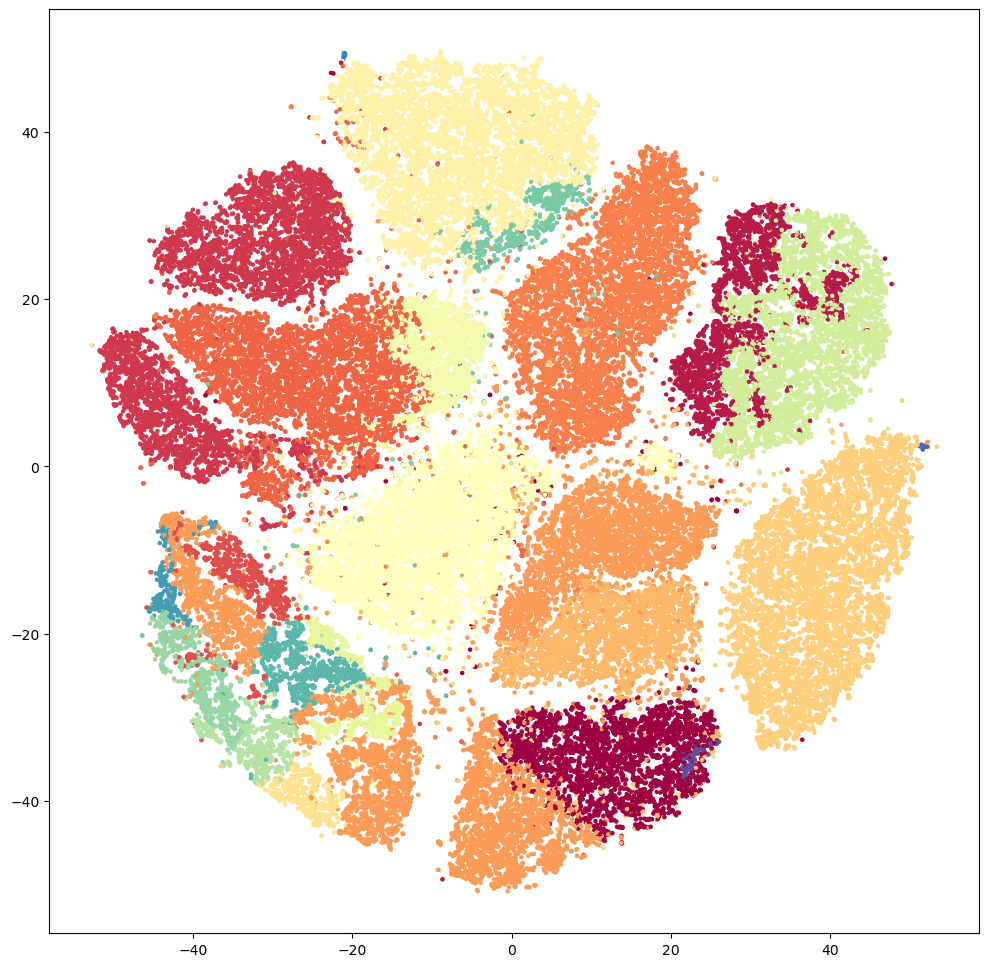

In [24]:
fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(*tsne_map.T, s=5, c=components, cmap="Spectral")

In [22]:
sklearn.metrics.adjusted_rand_score(digits.target, rj_labels)

0.661587508120778

In [23]:
sklearn.metrics.adjusted_mutual_info_score(digits.target, rj_labels)

0.7707472591313872

In [206]:
uhdb_labels = hdbscan.HDBSCAN().fit_predict(umap.UMAP().fit_transform(digits.data))

In [207]:
sklearn.metrics.adjusted_rand_score(digits.target, uhdb_labels)

0.8264501723117741

In [208]:
sklearn.metrics.adjusted_mutual_info_score(digits.target, uhdb_labels)

0.8647970417816774

In [58]:
import cdlib
import cdlib.algorithms
import networkx as nx

Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool', 'infomap', 'karateclub', 'wurlitzer'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'ASLPAw', 'karateclub'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'infomap', 'wurlitzer'}


In [59]:
def communities_to_label_vector(node_clustering):
    n_nodes = np.sum([len(x) for x in node_clustering.communities])
    result = np.full(n_nodes, -1, dtype=np.int32)
    for label, node_set in enumerate(node_clustering.communities):
        result[node_set] = label
    return result

In [ ]:
nx_graph = nx.from_scipy_sparse_matrix(new_graph)
ldn_labels = communities_to_label_vector(cdlib.algorithms.leiden(nx_graph))

In [ ]:
ldn_labels

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(*tsne_map.T, s=5, c=ldn_labels, cmap="tab20")

In [44]:
n_components, components = scipy.sparse.csgraph.connected_components(distance_graph)

In [45]:
for i in range(n_components):
    print(np.sum(components == i))

3573


In [46]:
n_components

1